# Sheet 2

# Network Construction

In [1]:
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import random
import scipy.stats as stats
from scipy.stats import ttest_1samp
import powerlaw

In [2]:
gender_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                        "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=0")

gender_df

,Name,ID,Gender
0,Monkey D. Luffy,1,M
1,Nami,2,F
2,Rorona Zolo/Zoro,3,M
3,Yoshimoto,4,M
4,Mayor Boodle,5,M
...,...,...,...
112,Kebi,113,M
113,Erik,114,M
114,Portgas D. Ace,115,M
115,Mr Mellow,116,M


In [3]:
def load_data():
    # Load the CSV file into a Pandas DataFrame
    df1 = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                      "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=1662456534")

    df2 = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                      "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=369654917")

    df3 = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                      "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=1514456482")

    df = pd.concat([df1, df2, df3])
    df = df.value_counts(['Char_1', 'Char_2', 'Interaction']).reset_index(name='Weight')
    return df

In [4]:
# create a directed multigraph with # of interactions summed to a weight
def init_graph(df):
    G = nx.MultiDiGraph()

    # loop through each interaction
    for index, row in df.iterrows():
        source_node = row['Char_1']
        target_node = row['Char_2']

        # mark the edge as pos/neg
        attributes = {'interaction': row['Interaction']}

        id_match_source = gender_df['ID'] == source_node
        id_match_target = gender_df['ID'] == target_node
        gender_source = gender_df.loc[id_match_source, 'Gender'].values[0]
        gender_target = gender_df.loc[id_match_target, 'Gender'].values[0]

        G.add_node(source_node, gender=gender_source)
        G.add_node(target_node, gender=gender_target)
        G.add_edge(source_node, target_node, **attributes, weight=row['Weight'])

    return G

In [5]:
# Create a directed multigraph where there can only be a pos/neg edge from a character to another character
def single_edges(G):
    G_copy = G.copy()

    for s in G_copy.nodes:
        for t in G_copy.nodes:
            if G_copy.number_of_edges(s, t) == 2:
                #print(G_copy.number_of_edges(s,t))
                # the pos/neg adge with the highest eright is kept
                if G_copy.get_edge_data(s, t)[0]['weight'] < G_copy.get_edge_data(s, t)[1]['weight']:
                    G_copy.remove_edge(s, t, key=0)
                else:
                    G_copy.remove_edge(s, t, key=1)

    return G_copy

In [6]:
def negative_graph(G_original):
    G = G_original.copy()

    for s in G.nodes:
        for t in G.nodes:
            if G.number_of_edges(s, t) > 0 and G.get_edge_data(s, t)[0]['interaction'] == 1:
                G.remove_edge(s, t)

    return G


def positive_graph(G_original):
    G = G_original.copy()

    for s in G.nodes:
        for t in G.nodes:
            if G.number_of_edges(s, t) > 0 and G.get_edge_data(s, t)[0]['interaction'] == 0:
                G.remove_edge(s, t)

    return G

In [7]:
# Create an undirected simple graph
def undirected_simple_graph(G):
    G_copy = G.copy()

    for source in G_copy.nodes:
        for target in G_copy.nodes:
            if G_copy.number_of_edges(source, target) + G_copy.number_of_edges(target, source) == 2:
                # the pos/neg adge with the highest weight is kept
                if G_copy.get_edge_data(source, target)[0]['weight'] < G_copy.get_edge_data(target, source)[0][
                    'weight']:
                    G_copy.remove_edge(source, target)
                else:
                    G_copy.remove_edge(target, source)

    G_undirected = nx.Graph(G_copy)
    return G_undirected

# Network Initialization

In [8]:
df = load_data()  # Whole dataset
df_pos = df[df['Interaction'] == 1]  # only positive interactions
df_neg = df[df['Interaction'] == 0]  # only negative interactions

G = init_graph(df)
G_pos = init_graph(df_pos)
G_neg = init_graph(df_neg)

G_single = single_edges(G)
G_single_pos = positive_graph(G_single)
G_single_neg = negative_graph(G_single)

G_undirected = undirected_simple_graph(G_single)

In [9]:
print(len(df))
print(len(df_pos))
print(len(df_neg))

1064
627
437


In [10]:
possible_relations = []
parallel_relations = []
for s in G.nodes:
    for t in G.nodes:
        if (t, s) in parallel_relations:
            continue

        if (t, s) not in possible_relations and G.number_of_edges(s, t) >= 1:
            possible_relations.append((s,t))

        
        if G.number_of_edges(s, t) == 2:
            parallel_relations.append((s, t))
            #print(G_copy.number_of_edges(s,t))

#print(parallel_relations)
print(len(parallel_relations))
print(len(possible_relations))
#print(G.number_of_edges(50,58))

167
455


In [11]:
def load_data_c():
    # Load the CSV file into a Pandas DataFrame
    df1 = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                      "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=1662456534")

    df2 = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                      "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=369654917")

    df3 = pd.read_csv("https://docs.google.com/spreadsheets/d/1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38" +
                      "/export?format=csv&id=1TU-kOEdeCKcPvlYjHBa4X0VxpW8RDWKco7aeJmRqQ38&gid=1514456482")

    df = pd.concat([df1, df2, df3])

    return df

In [12]:
count_edges = load_data_c()
print(len(count_edges))
print(len(count_edges[count_edges["Interaction"]==1]))
print(len(count_edges[count_edges["Interaction"]==0]))

3314
2440
874


# Visualization

In [13]:
def draw_graph(G, title=None, font_size=22, size=12, undirected=False):
    # Draw the graph
    pos = nx.kamada_kawai_layout(G)  # You can use different layout algorithms

    # Extract edge attributes for "interaction"
    edge_labels = {}
    for source, target, attr in G.edges(data=True):
        if "interaction" in attr:
            edge_labels[(source, target)] = attr["interaction"]

    # Create a list of edge colors based on the 'color' attribute
    edge_colors = ['green' if edge[2]['interaction'] == 1 else 'red' for edge in G.edges(data=True)]

    degree_centrality = nx.degree_centrality(G)
    scaling_factor = 1000  # Adjust this value as needed
    node_sizes = [scaling_factor * degree_centrality[node] for node in G.nodes()]

    # Normalize the edge weights
    def normalize_weights(weights):
        max_weight = max(weights)
        return [weight / max_weight for weight in weights]

    edge_weights = [edge[2]['weight'] for edge in G.edges(data=True)]
    normalized_edge_weights = normalize_weights(edge_weights)

    node_color = []
    color_mapping = {'M': 'lightblue', 'F': 'lightcoral'}

    for node in G.nodes:
        id_match = gender_df['ID'] == node
        if id_match.any():
            gender_value = gender_df.loc[id_match, 'Gender'].values[0]
            node_color.append(color_mapping.get(gender_value, 'grey'))

    plt.figure(3, figsize=(size, size))
    plt.title(title, {"fontsize": font_size})

    extra_kwargs = {} if undirected else {"connectionstyle": "arc3,rad=0.2"}

    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_color, font_size=10, font_color='black',
            font_weight='bold', edge_color=edge_colors, width=[w * 3 for w in normalized_edge_weights], **extra_kwargs)

    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.show()

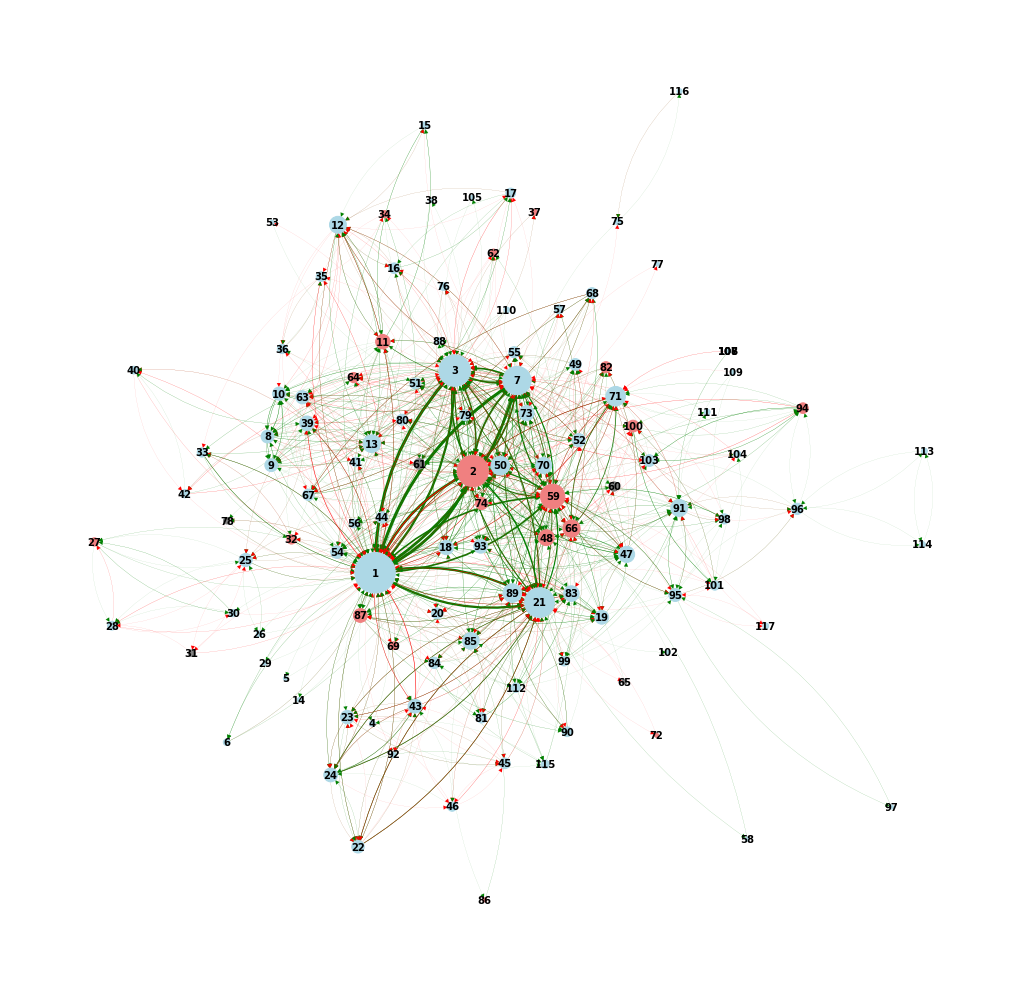

<Figure size 432x288 with 0 Axes>

In [189]:
draw_graph(G, '', size=18)

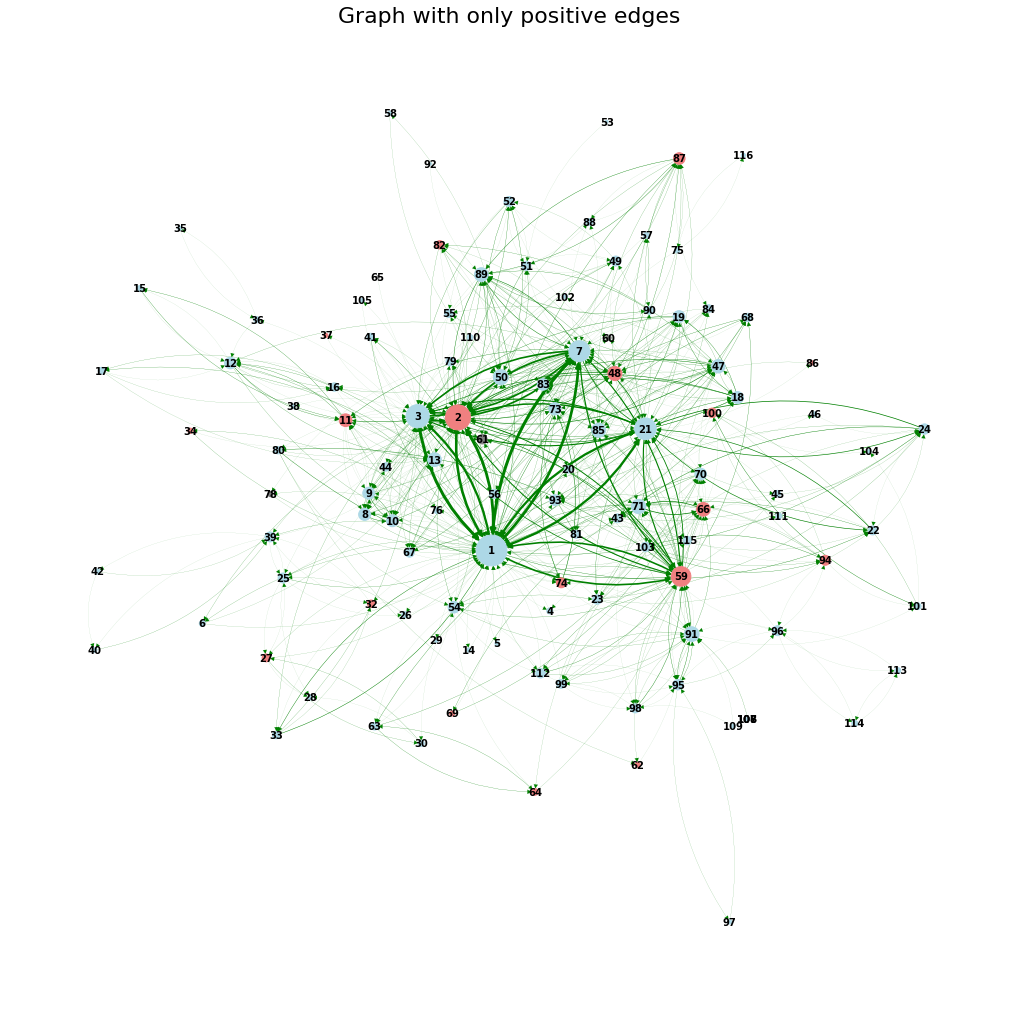

In [15]:
draw_graph(G_pos, 'Graph with only positive edges', size=18)

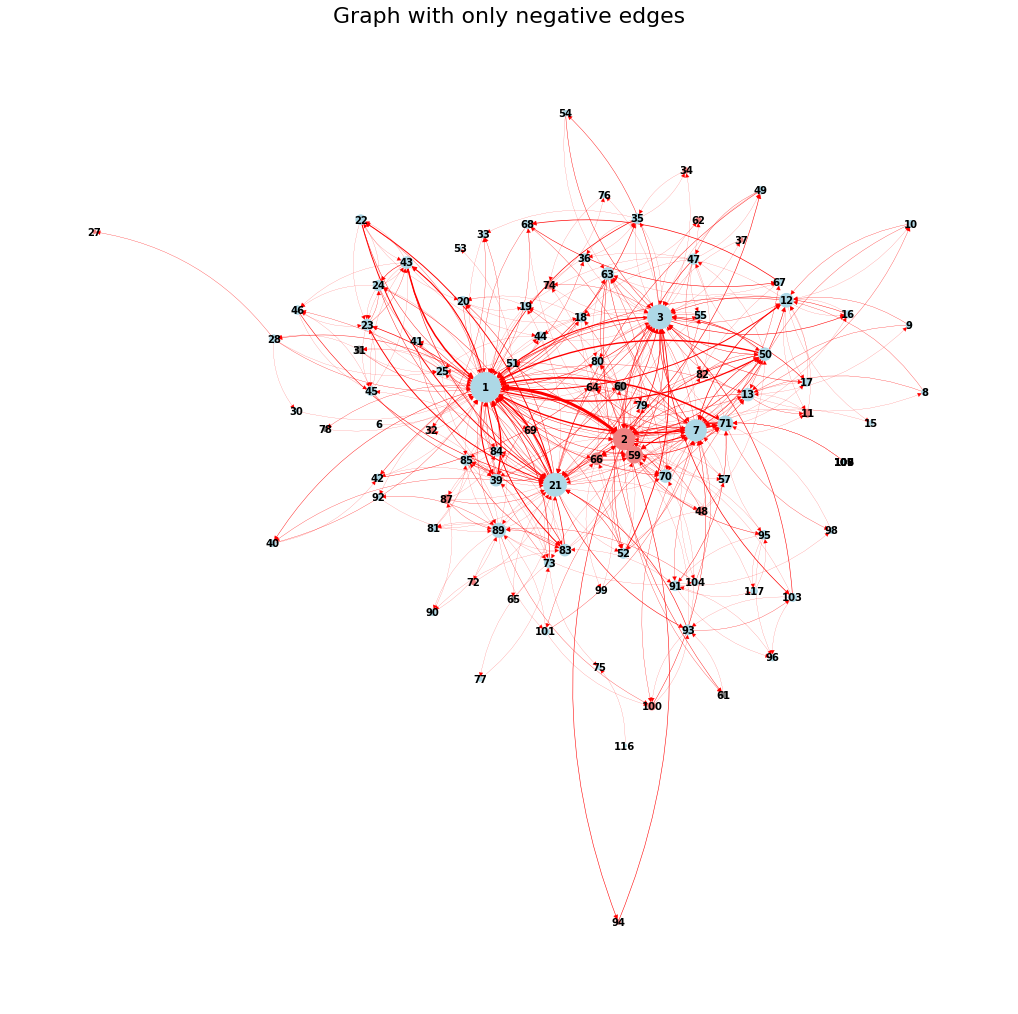

In [16]:
draw_graph(G_neg, 'Graph with only negative edges', size=18)

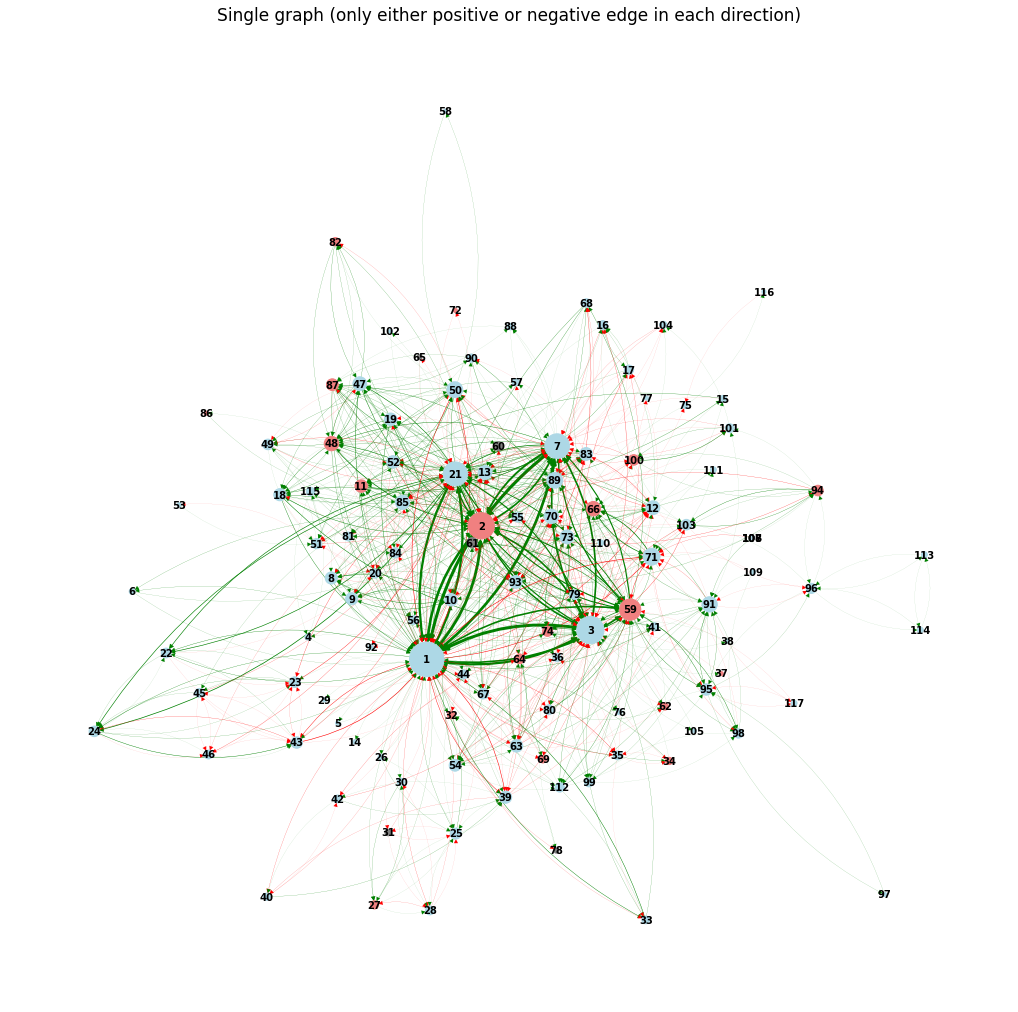

In [17]:
draw_graph(G_single, "Single graph (only either positive or negative edge in each direction)", 17, 18)

# Network Calculation 

## Degree Centrality

In [169]:
def centrality(G, gender=None):
    in_degree_centrality = nx.in_degree_centrality(G)
    in_degree_centrality = dict(sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True))

    out_degree_centrality = nx.out_degree_centrality(G)
    out_degree_centrality = dict(sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True))
    #print('in_degree_centrality', in_degree_centrality[i], list(in_degree_centrality).index(i))                                                                                                                                                     
    i = 66

    d = dict(
        zip(in_degree_centrality.keys(), pd.Series(in_degree_centrality.values()).rank(ascending=False).tolist()))
    print(d)
    print(in_degree_centrality)
    print(in_degree_centrality[i])
    print(d[i])
    #print('in_degree_centrality', out_degree_centrality[i])
    # Set a threshold to identify hubs
    threshold = 0.1  # Adjust this value as needed

    # Identify hubs (nodes with in-degree centrality or out-degree centrality above the threshold)
    in_hubs = [node for node in in_degree_centrality.keys() if in_degree_centrality[node] > threshold]
    out_hubs = [node for node in out_degree_centrality.keys() if out_degree_centrality[node] > threshold]

    #print("In Hubs:", in_hubs)
    #print("Out Hubs:", out_hubs)

    if gender:
        centralities = []
        for node in in_degree_centrality:
            #print(node)
            #print(G.nodes[node].get('gender') )
            if G.nodes[node].get('gender') == gender:
                centralities.append(in_degree_centrality[node])
                #print(in_degree_centrality[node])
        print('gender: ', gender, centralities)
        return centralities


#i = 10
centrality(G)
#centrality(G_neg)
#centrality(G_pos)
#centralities_f = centrality(G, 'F')
#centralities_m = centrality(G, 'M')
#print(centralities_f)
#print(centralities_m)

{1: 1.0, 3: 2.0, 2: 3.0, 21: 4.0, 7: 5.0, 59: 6.0, 71: 7.0, 89: 8.0, 50: 9.0, 91: 10.5, 13: 10.5, 12: 12.0, 66: 13.5, 70: 13.5, 85: 15.0, 83: 16.0, 47: 19.0, 18: 19.0, 73: 19.0, 19: 19.0, 93: 19.0, 48: 23.0, 39: 23.0, 11: 23.0, 24: 25.5, 23: 25.5, 43: 28.5, 10: 28.5, 95: 28.5, 25: 28.5, 22: 34.0, 8: 34.0, 87: 34.0, 9: 34.0, 52: 34.0, 79: 34.0, 63: 34.0, 74: 41.5, 61: 41.5, 100: 41.5, 67: 41.5, 51: 41.5, 54: 41.5, 84: 41.5, 96: 41.5, 80: 50.5, 98: 50.5, 68: 50.5, 82: 50.5, 49: 50.5, 64: 50.5, 16: 50.5, 20: 50.5, 55: 50.5, 44: 50.5, 33: 57.5, 94: 57.5, 103: 57.5, 45: 57.5, 101: 66.5, 35: 66.5, 81: 66.5, 41: 66.5, 112: 66.5, 90: 66.5, 17: 66.5, 57: 66.5, 46: 66.5, 99: 66.5, 28: 66.5, 32: 66.5, 60: 66.5, 36: 66.5, 56: 77.5, 40: 77.5, 27: 77.5, 42: 77.5, 115: 77.5, 62: 77.5, 104: 77.5, 76: 77.5, 15: 85.0, 69: 85.0, 30: 85.0, 34: 85.0, 78: 85.0, 75: 85.0, 88: 85.0, 6: 93.5, 31: 93.5, 92: 93.5, 26: 93.5, 111: 93.5, 114: 93.5, 4: 93.5, 113: 93.5, 117: 93.5, 37: 93.5, 58: 105.5, 86: 105.5, 97: 

## Betweenness & Closeness Centrality

In [188]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))

closeness_centrality = nx.closeness_centrality(G)
closeness_centrality = dict(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))

betweenness = dict(zip(betweenness_centrality.keys(), pd.Series(betweenness_centrality.values()).rank(ascending=False).tolist()))
closeness = dict(zip(closeness_centrality.keys(), pd.Series(closeness_centrality.values()).rank(ascending=False).tolist()))

print('Betweeness rank & value:')
print(betweenness)
print(betweenness_centrality)

print('Closeness rank & value:')
print(closeness)
print(closeness_centrality)



Betweeness rank & value:
{1: 1.0, 3: 2.0, 21: 3.0, 2: 4.0, 7: 5.0, 59: 6.0, 71: 7.0, 73: 8.0, 96: 9.0, 89: 10.0, 50: 11.0, 95: 12.0, 91: 13.0, 85: 14.0, 66: 15.0, 103: 16.0, 51: 17.0, 75: 18.0, 94: 19.0, 83: 20.0, 12: 21.0, 93: 22.0, 74: 23.0, 87: 24.0, 112: 25.0, 11: 26.0, 48: 27.0, 39: 28.0, 54: 29.0, 70: 30.0, 52: 31.0, 13: 32.0, 47: 33.0, 43: 34.0, 100: 35.0, 24: 36.0, 23: 37.0, 44: 38.0, 63: 39.0, 49: 40.0, 79: 41.0, 99: 42.0, 101: 43.0, 84: 44.0, 25: 45.0, 19: 46.0, 18: 47.0, 67: 48.0, 115: 49.0, 40: 50.0, 80: 51.0, 42: 52.0, 33: 53.0, 61: 54.0, 98: 55.0, 10: 56.0, 35: 57.0, 8: 58.5, 9: 58.5, 17: 60.0, 56: 61.0, 36: 62.0, 55: 63.0, 32: 64.0, 20: 65.0, 64: 66.0, 22: 67.0, 28: 68.0, 68: 69.0, 104: 70.0, 88: 71.0, 46: 72.5, 45: 72.5, 16: 74.0, 27: 75.0, 60: 76.0, 81: 77.0, 90: 78.0, 15: 98.0, 41: 98.0, 69: 98.0, 82: 98.0, 57: 98.0, 30: 98.0, 34: 98.0, 6: 98.0, 31: 98.0, 58: 98.0, 92: 98.0, 86: 98.0, 62: 98.0, 110: 98.0, 97: 98.0, 78: 98.0, 26: 98.0, 77: 98.0, 76: 98.0, 116: 98.0, 72

## Degree Distribution

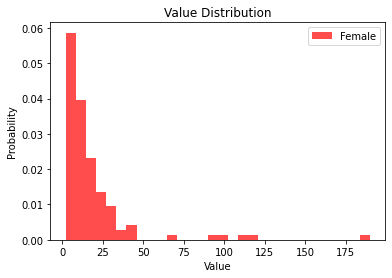

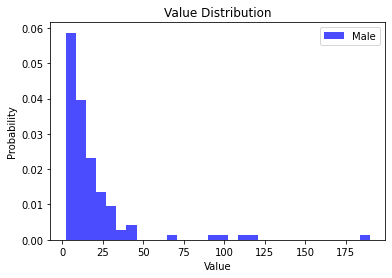

In [20]:
def degree_distribution(G, label, color):
    if label == "Female":
        pass
    degrees = [G.degree(n) for n in G.nodes()]
    # This is a list of unique values appearing in the input list
    #degrees_unique = list(set(degrees))
    #print(degrees_unique)
    # This is the corresponding count for each value
    #counts = [degrees.count(value) for value in degrees_unique]
    #print(counts)
    #plt.bar(degrees_unique,counts)
    plt.hist(degrees, bins=30, density=True, alpha=0.7, color=color, label=label)
    plt.title("Value Distribution")
    plt.xlabel("Value")
    plt.ylabel("Probability")
    #plt.xlim(0, 1)
    #plt.ylim(0, 30)
    plt.legend()
    plt.show()


degree_distribution(G, 'Female', 'red')
degree_distribution(G, 'Male', 'blue')

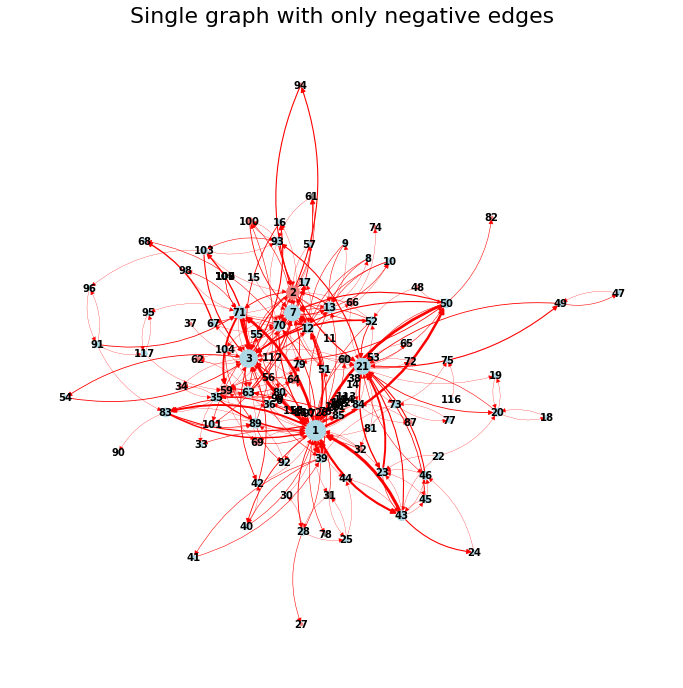

In [21]:
draw_graph(G_single_neg, 'Single graph with only negative edges')

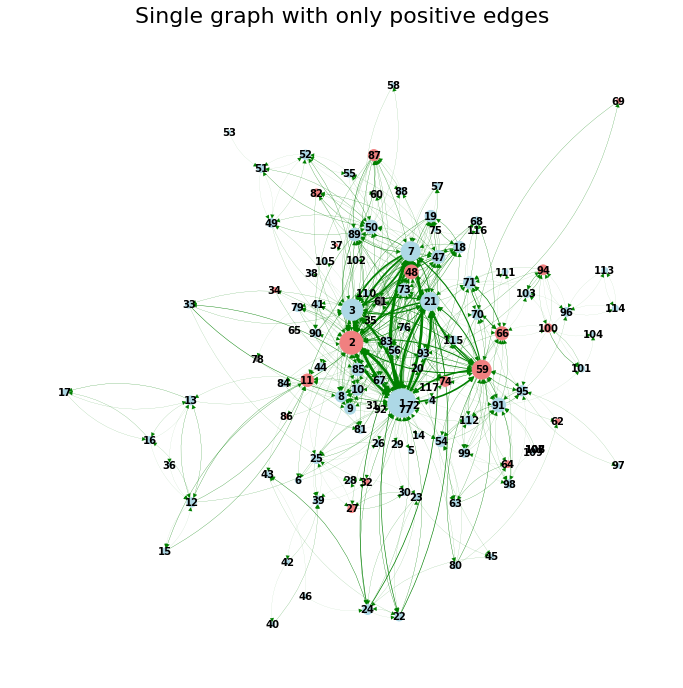

In [22]:
draw_graph(G_single_pos, 'Single graph with only positive edges')

[70, 137, 86, 67, 13, 33, 11, 22, 15, 17, 29, 17, 22, 29, 12, 7, 17, 18, 15, 13, 19, 22, 18, 11, 23, 10, 17, 9, 18, 13, 13, 9, 5, 11, 9, 12, 9, 24, 18, 8, 27, 10, 8, 19, 22, 10, 6, 13, 14, 9, 9, 16, 9, 6, 6, 10, 7, 9, 4, 12, 9, 9, 11, 5, 10, 8, 2, 3, 4, 6, 2, 12, 9, 3, 8, 4, 2, 4, 4, 2, 2, 4, 5, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 3, 2, 3, 2, 2]
[42, 92, 51, 61, 38, 41, 11, 16, 20, 22, 8, 20, 4, 15, 20, 8, 11, 16, 18, 9, 5, 18, 14, 14, 12, 5, 10, 10, 15, 5, 14, 18, 8, 14, 8, 5, 10, 11, 7, 9, 0, 4, 7, 7, 7, 7, 12, 6, 6, 22, 10, 7, 11, 9, 2, 7, 4, 4, 9, 10, 9, 5, 2, 14, 6, 2, 7, 4, 3, 3, 3, 9, 4, 5, 3, 3, 4, 6, 0, 7, 8, 2, 0, 2, 3, 4, 2, 2, 9, 3, 2, 2, 4, 0, 4, 2, 1, 0, 2, 4, 5, 2, 2, 2, 4, 4, 4, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1]
[28, 45, 35, 19, 29, 11, 2, 17, 4, 2, 3, 2, 11, 2, 9, 9, 1, 6, 11, 3, 2, 0, 3, 4, 3, 8, 9, 12, 3, 6, 2, 5, 2, 3, 5, 4, 8, 2, 6, 4, 9, 1, 4, 2, 5, 2, 12, 12, 2, 5, 0, 1, 8, 13, 4, 1, 6, 2, 4, 4, 0, 6, 7, 2, 3, 4, 1, 2, 3, 7, 4, 0, 0, 7, 6, 6, 3, 5, 5, 3, 0, 0, 3, 0, 3, 0, 

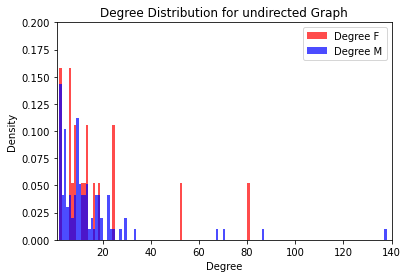

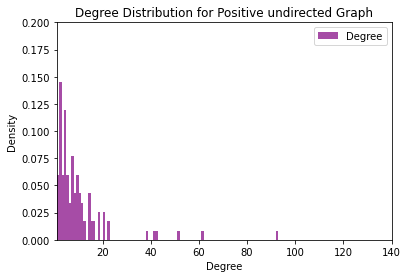

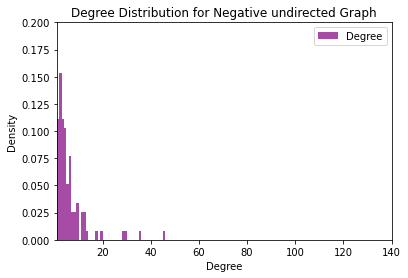

In [23]:
in_degrees_negative = list(dict(G_single_neg.in_degree()).values())
out_degrees_negative = list(dict(G_single_neg.out_degree()).values())

in_degrees_positive = list(dict(G_single_pos.in_degree()).values())
out_degrees_positive = list(dict(G_single_pos.out_degree()).values())

def degree_distribution(G, split_gender, title):
 
    degree = dict(G.degree())
    #plt.figure(figsize=(15,15))

    if split_gender:
        degrees_F = []
        degrees_M = []

        for node in list(G.nodes):
            #print(node)
            #print(G.nodes[node].get('gender') )
            if G.nodes[node].get('gender') == 'F':
                degrees_F.append(degree[node])
            else:
                degrees_M.append(degree[node])

        print(degrees_M)
        #print(list(range(0, max(degrees) + 2, 1)))
        plt.hist(degrees_F, bins=range(0, max(degrees_M) + 2, 1), density=True, alpha=0.7, color="red",
                 label='Degree F')
        plt.hist(degrees_M, bins=range(0, max(degrees_M) + 2, 1), density=True, alpha=0.7, color="blue",
                 label='Degree M')
    else:
        degrees = list(degree.values())
        print(degrees)

        plt.hist(degrees, bins=range(0, max(degrees) + 2, 1), density=True, alpha=0.7, color="purple", label='Degree')

    plt.title(title)

    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.xlim(1, 140)
    plt.ylim(0, 0.2)
    plt.legend()
    plt.show()


degree_distribution(G_single, True, "Degree Distribution for undirected Graph")
degree_distribution(G_single_pos, False, "Degree Distribution for Positive undirected Graph")
degree_distribution(G_single_neg, False, "Degree Distribution for Negative undirected Graph")

#degree_distribution(G_single, 'out-degree negative', 'red')
#degree_distribution(G_single, 'out-degree positive', 'blue')


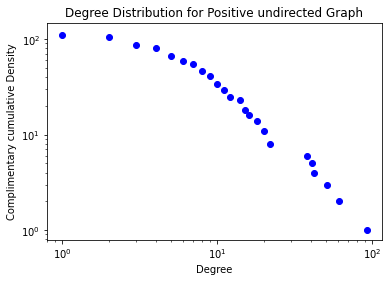

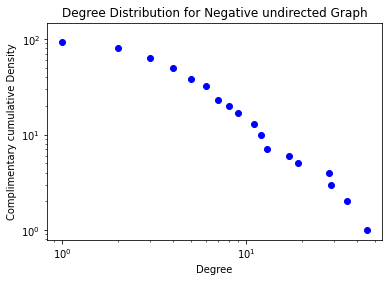

In [24]:
def degree_distribution(G, split_gender, title):


    degrees = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degrees)
    deg, cnt = zip(*degreeCount.items())
    cs = np.cumsum(cnt)
    plt.loglog(deg, cs, 'bo')


    plt.title(title)
    plt.ylabel("Complimentary cumulative Density")
    plt.xlabel("Degree")
    plt.show()


#degree_distribution(G_single, True, "Degree Distribution for unDirected Graph")
degree_distribution(G_single_pos, False, "Degree Distribution for Positive undirected Graph")
degree_distribution(G_single_neg, False, "Degree Distribution for Negative undirected Graph")

In [25]:
dict(G.in_degree())

{7: 47,
 1: 97,
 3: 60,
 2: 58,
 21: 51,
 59: 35,
 24: 11,
 71: 22,
 66: 16,
 48: 12,
 22: 9,
 47: 13,
 43: 10,
 18: 13,
 50: 19,
 39: 12,
 74: 8,
 73: 13,
 89: 20,
 61: 8,
 33: 6,
 11: 12,
 8: 9,
 10: 10,
 95: 10,
 23: 11,
 83: 14,
 12: 17,
 19: 13,
 80: 7,
 87: 9,
 85: 15,
 98: 7,
 9: 9,
 100: 8,
 101: 5,
 52: 9,
 94: 6,
 103: 6,
 67: 8,
 35: 5,
 15: 3,
 79: 9,
 68: 7,
 51: 8,
 81: 5,
 70: 16,
 63: 9,
 41: 5,
 91: 18,
 112: 5,
 90: 5,
 93: 13,
 13: 18,
 69: 3,
 82: 7,
 17: 5,
 57: 5,
 49: 7,
 25: 10,
 56: 4,
 64: 7,
 46: 5,
 54: 8,
 16: 7,
 40: 4,
 27: 4,
 30: 3,
 34: 3,
 20: 7,
 42: 4,
 99: 5,
 6: 2,
 84: 8,
 28: 5,
 45: 6,
 32: 5,
 55: 7,
 31: 2,
 44: 7,
 115: 4,
 58: 1,
 92: 2,
 86: 1,
 62: 4,
 110: 0,
 104: 4,
 97: 1,
 96: 8,
 60: 5,
 78: 3,
 36: 5,
 26: 2,
 77: 1,
 76: 4,
 75: 3,
 116: 1,
 72: 1,
 29: 1,
 111: 2,
 88: 3,
 105: 1,
 102: 1,
 5: 1,
 114: 2,
 4: 2,
 113: 2,
 117: 2,
 108: 0,
 106: 0,
 107: 0,
 109: 0,
 14: 1,
 65: 1,
 37: 2,
 38: 1,
 53: 1}

# Triad Analysis

1. Undirected network
2. Count balanced and unbalanced triads
3. Compare with random network (random assignment of interaction between edges)

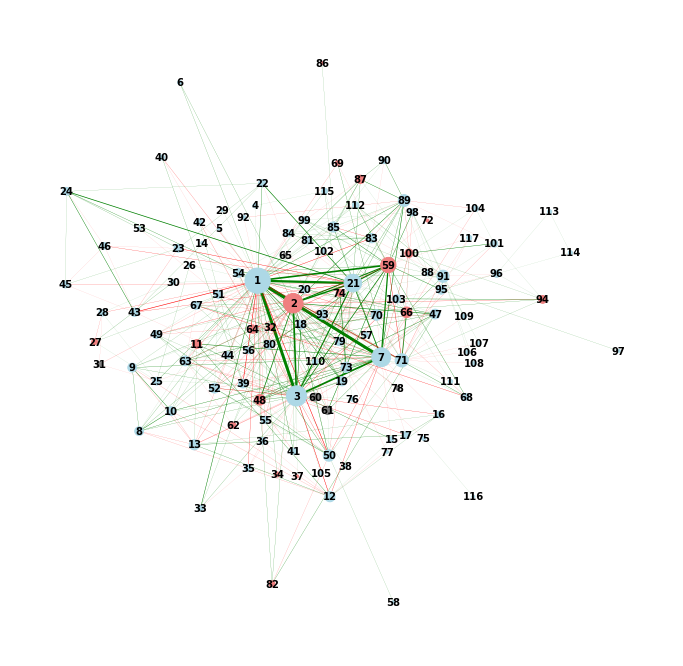

In [26]:
draw_graph(G_undirected, undirected=True)

In [27]:
print(nx.triangles(G_undirected))
triangles = [c for c in nx.cycle_basis(G_undirected) if len(c) == 3]
triangles

{7: 170, 1: 255, 3: 162, 2: 173, 21: 138, 59: 105, 24: 17, 71: 57, 66: 29, 48: 47, 22: 12, 47: 31, 43: 18, 18: 30, 50: 52, 39: 16, 74: 6, 73: 24, 89: 45, 61: 22, 33: 4, 11: 29, 8: 34, 10: 34, 95: 14, 23: 17, 83: 26, 12: 39, 19: 34, 80: 21, 87: 16, 85: 36, 98: 10, 9: 34, 100: 13, 101: 7, 52: 39, 94: 10, 103: 13, 67: 16, 35: 7, 15: 3, 79: 20, 68: 9, 51: 13, 81: 14, 70: 43, 63: 33, 41: 6, 91: 26, 112: 7, 90: 5, 93: 33, 13: 44, 69: 3, 82: 6, 17: 10, 57: 3, 49: 16, 25: 8, 56: 9, 64: 18, 46: 10, 54: 22, 16: 10, 40: 3, 27: 5, 30: 3, 34: 3, 20: 12, 42: 5, 99: 7, 6: 1, 84: 13, 28: 7, 45: 10, 32: 4, 55: 13, 31: 3, 44: 5, 115: 4, 58: 0, 92: 1, 86: 0, 62: 6, 110: 6, 104: 6, 97: 0, 96: 3, 60: 19, 78: 1, 36: 8, 26: 1, 77: 0, 76: 1, 75: 0, 116: 0, 72: 0, 29: 0, 111: 1, 88: 2, 105: 0, 102: 1, 5: 0, 114: 1, 4: 1, 113: 1, 117: 3, 108: 1, 106: 1, 107: 1, 109: 3, 14: 0, 65: 1, 37: 0, 38: 0, 53: 0}


[[7, 110, 1],
 [2, 110, 1],
 [3, 110, 1],
 [3, 44, 1],
 [2, 44, 1],
 [43, 44, 1],
 [25, 44, 1],
 [25, 31, 1],
 [28, 31, 1],
 [3, 55, 1],
 [2, 55, 1],
 [47, 55, 1],
 [50, 55, 1],
 [52, 55, 1],
 [59, 99, 1],
 [66, 99, 1],
 [59, 91, 99],
 [66, 91, 99],
 [98, 91, 99],
 [71, 109, 91],
 [98, 109, 91],
 [71, 107, 91],
 [71, 106, 91],
 [71, 108, 91],
 [95, 117, 91],
 [59, 117, 91],
 [100, 94, 101],
 [100, 103, 94],
 [2, 103, 94],
 [71, 103, 94],
 [96, 103, 94],
 [93, 103, 94],
 [100, 104, 101],
 [89, 104, 101],
 [7, 104, 101],
 [89, 100, 101],
 [7, 100, 101],
 [95, 96, 91],
 [114, 113, 96],
 [71, 95, 91],
 [66, 95, 91],
 [59, 95, 91],
 [112, 95, 91],
 [98, 95, 91],
 [59, 98, 99],
 [3, 42, 1],
 [40, 42, 1],
 [39, 42, 1],
 [39, 25, 1],
 [28, 25, 1],
 [27, 25, 1],
 [26, 25, 1],
 [59, 69, 1],
 [70, 69, 1],
 [7, 70, 1],
 [2, 70, 1],
 [21, 70, 1],
 [59, 70, 1],
 [71, 70, 1],
 [66, 70, 1],
 [63, 70, 1],
 [68, 70, 1],
 [67, 70, 1],
 [64, 70, 1],
 [93, 70, 1],
 [89, 81, 1],
 [83, 81, 1],
 [85, 81, 1],


In [28]:
def make_triads(G):
    triangle_types = {}
    for triangle in triangles:
        tri = nx.subgraph(G, triangle)

        for x in tri.edges(data=True):
            if x[2]['interaction'] == 0:
                x[2]['interaction'] = -1

            #print(x[2])
        #take the product of the edge relationships. If there are an odd number of -1s, the triangle is unbalanced.
        triangle_types[tuple(tri.nodes())] = np.sum([x[2]['interaction'] for x in tri.edges(data=True)])
    #print(triangle_types)
    return triangle_types


triangle_types = make_triads(G_undirected)

In [29]:
print(G_undirected.get_edge_data(48, 57))
print(G_undirected.get_edge_data(57, 2))
print(G_undirected.get_edge_data(2, 48))

{'interaction': 1, 'weight': 4}
{'interaction': -1, 'weight': 1}
{'interaction': 1, 'weight': 14}


In [30]:
for k, v in triangle_types.items(): 
    if v == -3:
        print(k)

(1, 28, 31)
(40, 1, 42)
(1, 70, 71)
(1, 35, 36)
(43, 21, 46)
(43, 46, 23)
(43, 45, 46)
(43, 45, 21)
(17, 3, 12)
(3, 62, 63)
(80, 1, 63)
(1, 12, 36)


In [31]:
triangle_types = make_triads(G_undirected)
# Count the occurrences of each balance/unbalanced triad
value_counts = Counter(triangle_types.values())
print(value_counts[-1])

# Print the result
for value, count in value_counts.items():
    print(f"Value {value} occurs {count} times.")

triangle_types = make_triads(G_undirected)
# Count the occurrences of each balance/unbalanced triad
value_counts = Counter(triangle_types.values())
print(value_counts[-1])

# Print the result
for value, count in value_counts.items():
    print(f"Value {value} occurs {count} times.")

108
Value 3 occurs 138 times.
Value -1 occurs 108 times.
Value 1 occurs 63 times.
Value -3 occurs 12 times.
108
Value 3 occurs 138 times.
Value -1 occurs 108 times.
Value 1 occurs 63 times.
Value -3 occurs 12 times.


In [32]:
G_random = nx.Graph(G_undirected.copy())

In [33]:
def shuffle_interactions(n):
    ppp, nnn, pnn, ppn = [], [], [], []
    for i in range(n):
        shuffled_values = list(nx.get_edge_attributes(G_random, 'interaction').values())
        random.shuffle(shuffled_values)

        for edge, value in zip(G_random.edges, shuffled_values):
            G_random[edge[0]][edge[1]]['interaction'] = value

        triangle_types_random = make_triads(G_random)
        # Count the occurrences of each balance/unbalanced triad
        value_counts_random = Counter(triangle_types_random.values())
        for value, count in value_counts_random.items():
            if value == 3:
                ppp.append(count)
            elif value == 1:
                ppn.append(count)
            elif value == -1:
                pnn.append(count)
            else:
                nnn.append(count)
    return ppp, nnn, pnn, ppn

In [34]:
ppp, nnn, pnn, ppn = shuffle_interactions(1000)
random_triangles = {'3': ppp, '-3': nnn, '-1': pnn, '1': ppn}

In [35]:
def p_values(random_triangles, triangle_types):
    original_triangles = Counter(triangle_types.values())

    for (triangle_type, triangles) in random_triangles.items():
        #print(triangle_type, triangles)
        #print(original_triangles[int(triangle_type)])
        triangle_type = int(triangle_type)
        print(triangle_type)
        if triangle_type == 3 or triangle_type == -1:
            print(sum(np.array(triangles) > original_triangles[triangle_type]) / len(triangles))
        else:
            print(sum(np.array(triangles) < original_triangles[triangle_type]) / len(triangles))
        print(" ")


p_values(random_triangles, triangle_types)

3
0.0
 
-3
0.234
 
-1
0.048
 
1
0.0
 


In [36]:
sum(np.array(ppp) > 111)

25

In [37]:
# Perform an independent two-sample t-test
for group1, group2 in zip(ppp, [9]):
    t_statistic, p_value = stats.ttest_ind(group1, group2)

    # Print the results
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

    # Check if the p-value is less than the significance level (e.g., 0.05) to determine statistical significance
    if p_value < 0.05:
        print("The difference between the groups is statistically significant.")
    else:
        print("There is not enough evidence to conclude a significant difference between the groups.")

t-statistic: nan
p-value: nan
There is not enough evidence to conclude a significant difference between the groups.


<ipython-input-37-dd687467827f>:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(group1, group2)
/opt/python/envs/default/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/python/envs/default/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


/opt/python/envs/default/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


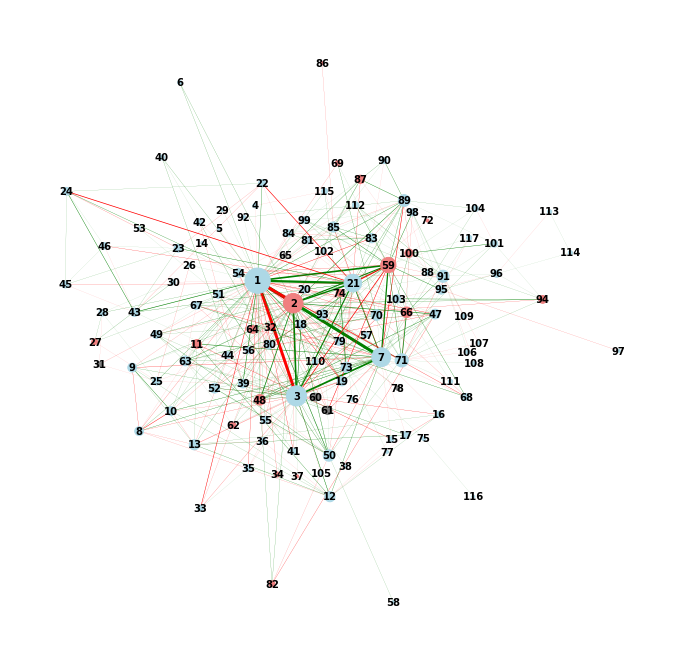

In [38]:
draw_graph(G_random)

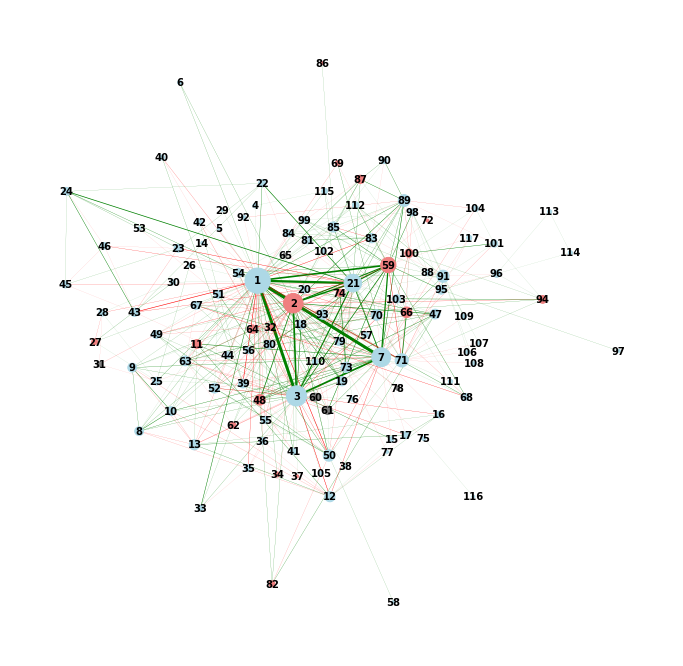

In [39]:
draw_graph(G_undirected)

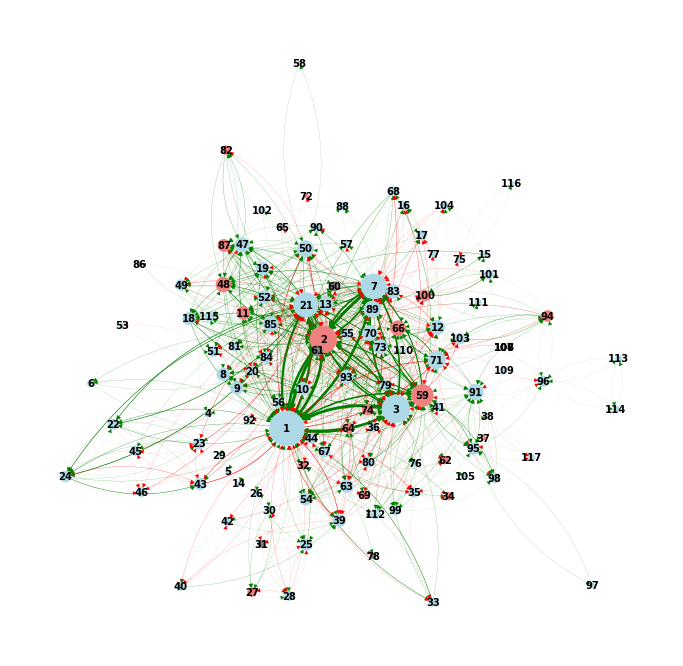

In [40]:
draw_graph(G_single)

In [41]:
print(G_single.get_edge_data(1, 3))
print(G_single.get_edge_data(3, 1))

{0: {'interaction': 1, 'weight': 44}}
{0: {'interaction': 1, 'weight': 57}}


In [42]:
G_single.nodes

NodeView((7, 1, 3, 2, 21, 59, 24, 71, 66, 48, 22, 47, 43, 18, 50, 39, 74, 73, 89, 61, 33, 11, 8, 10, 95, 23, 83, 12, 19, 80, 87, 85, 98, 9, 100, 101, 52, 94, 103, 67, 35, 15, 79, 68, 51, 81, 70, 63, 41, 91, 112, 90, 93, 13, 69, 82, 17, 57, 49, 25, 56, 64, 46, 54, 16, 40, 27, 30, 34, 20, 42, 99, 6, 84, 28, 45, 32, 55, 31, 44, 115, 58, 92, 86, 62, 110, 104, 97, 96, 60, 78, 36, 26, 77, 76, 75, 116, 72, 29, 111, 88, 105, 102, 5, 114, 4, 113, 117, 108, 106, 107, 109, 14, 65, 37, 38, 53))

In [43]:
import numpy as np
import pandas as pd
import networkx as nx
import powerlaw as pl
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Power law

In [44]:
# Load the data and redo the CCDF.
#G = nx.read_edgelist("../4/data.txt", delimiter = "\t")
dd = Counter(dict(G_single_pos.degree).values())
dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
ccdf = dd.sort_values(by = "k", ascending = False)
ccdf["cumsum"] = ccdf["count"].cumsum()
ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")

In [45]:
# With the powerlaw package, fitting the CCDf is simple. It will store results in the .power_law property. To
# get the actual k_min, we need to find the degree value corresponding to the probability in .power_law.xmin:
# pandas makes it easy. This is definitely a shifted power law. (Kappa contains the intercept information)
results = pl.Fit(ccdf["ccdf"])
k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 12.3528 x ^ -1.8733 (k_min = 18)


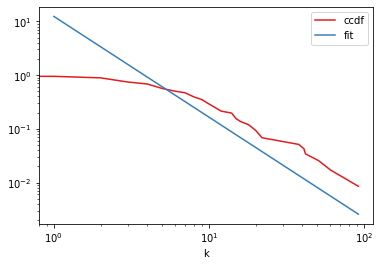

In [46]:
# Let's plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
plt.savefig("ccdf_fit.png")

In [47]:
results.distribution_compare('power_law', 'lognormal')

(-3.0146009330113843, 0.17268971914481857)

In [102]:
def powerlaw(G):
    # Load the data and redo the CCDF.
    #G = nx.read_edgelist("../4/data.txt", delimiter = "\t")
    dd = Counter(dict(G.degree).values())
    dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
    ccdf = dd.sort_values(by = "k", ascending = False)
    ccdf["cumsum"] = ccdf["count"].cumsum()
    ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
    ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")

    # With the powerlaw package, fitting the CCDf is simple. It will store results in the .power_law property. To
    # get the actual k_min, we need to find the degree value corresponding to the probability in .power_law.xmin:
    # pandas makes it easy. This is definitely a shifted power law. (Kappa contains the intercept information)
    results = pl.Fit(ccdf["ccdf"])
    k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
    print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))
    print(results.lognormal.mu)

    # Let's plot the best fit.
    ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
    ccdf["fit_lognormal"] = (10 ** results.lognormal.mu) * (ccdf["k"] ** -results.lognormal.sigma)
    ax = plt.gca()
    ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
    ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
    #ccdf.plot(kind = "line", x = "k", y = "fit_lognormal", color = "#378eb8", loglog = True, ax = ax)
    plt.savefig("ccdf_fit.png")
    #results.power_law.plot_ccdf(ax = ax, color = 'g', linestyle = '-')
    #results.lognormal.plot_ccdf(ax = ax, color = 'g', linestyle = '-')

    print(results.distribution_compare('power_law', 'truncated_power_law'))
    print(results.distribution_compare('power_law', 'lognormal'))
    print(results.distribution_compare('power_law', 'exponential'))
    print(results.distribution_compare('lognormal', 'exponential'))
    print(results.distribution_compare('truncated_power_law', 'lognormal'))
    print(results.distribution_compare('truncated_power_law', 'exponential'))


Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 12.3787 x ^ -2.0537 (k_min = 9)
-1.3896328031126006
(-1.197342875538296, 0.12174821302619776)
(-0.9711597791436574, 0.4467349300563487)
(-1.3269919581519665, 0.4056065721227424)
(-0.3558321790083092, 0.3213195112533628)
(0.22618309639463846, 0.5976288452877965)
(-0.12964908261367075, 0.8561611821565979)


Assuming nested distributions


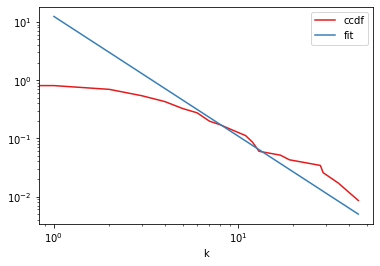

In [103]:
powerlaw(G_single_neg)

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 12.3528 x ^ -1.8733 (k_min = 18)
(-2.908063101814496, 0.01587988161381748)
(-3.0146009330113843, 0.17268971914481857)
(-3.7492408989115016, 0.08127336881536582)
(-0.7346399659001167, 0.031152348349462764)
(-0.10653783119688953, 0.9279862845196777)
(-0.8411777970970064, 0.4363596461031184)


Assuming nested distributions


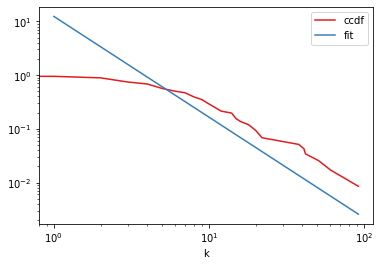

In [58]:
powerlaw(G_single_pos)

In [104]:
def powerlaw2(G):
    # Load the data and redo the CCDF.
    #G = nx.read_edgelist("../4/data.txt", delimiter = "\t")
    dd = Counter(dict(G.degree).values())
    dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
    ccdf = dd.sort_values(by = "k", ascending = False)
    ccdf["cumsum"] = ccdf["count"].cumsum()
    ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
    ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")

    # With the powerlaw package, fitting the CCDf is simple. It will store results in the .power_law property. To
    # get the actual k_min, we need to find the degree value corresponding to the probability in .power_law.xmin:
    # pandas makes it easy. This is definitely a shifted power law. (Kappa contains the intercept information)
    results = pl.Fit(ccdf["ccdf"], discrete=True)
    k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
    print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))
    print(results.lognormal)

    # Let's plot the best fit.
    ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
    #ccdf["fit_lognormal"] = (10 ** results.lognormal.Kappa) * (ccdf["k"] ** -results.lognormal.alpha)
    #ax = plt.gca()
    #ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
    #ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
    #ccdf.plot(kind = "line", x = "k", y = "fit_lognormal", color = "#378eb8", loglog = True, ax = ax)
    #plt.savefig("ccdf_fit.png")
    fig = results.plot_ccdf(linewidth=3, label='Empirical Data')
    results.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
    results.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
    results.truncated_power_law.plot_ccdf(ax=fig, color='b', linestyle='--', label='Truncated Power law fit')
    results.exponential.plot_ccdf(ax=fig, color='y', linestyle='--', label='exponential')
    fig.set_ylabel(u"p(X≥x)")
    fig.set_xlabel("Word Frequency")
    handles, labels = fig.get_legend_handles_labels()
    fig.legend(handles, labels, loc=3)

    figname = 'FigLognormal'
    #savefig(figname+'.eps', bbox_inches='tight')
    #savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

    print(results.distribution_compare('power_law', 'truncated_power_law'))
    print(results.distribution_compare('power_law', 'lognormal'))
    print(results.distribution_compare('power_law', 'exponential'))
    print(results.distribution_compare('lognormal', 'exponential'))
    print(results.distribution_compare('truncated_power_law', 'lognormal'))
    print(results.distribution_compare('truncated_power_law', 'exponential'))

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 10.8464 x ^ -1.3988 (k_min = 14)
(-4.042154080283386, 0.004465017315583686)
(nan, nan)
(-9.900056150032382, 2.710870141415283e-11)
(nan, nan)
(nan, nan)
(-5.857902069748995, 1.6138665497398782e-08)


/opt/python/envs/default/lib/python3.8/site-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/opt/python/envs/default/lib/python3.8/site-packages/powerlaw.py:1558: RuntimeWarning: invalid value encountered in log
  arg1 = (np.log(lower_data)-self.mu) / (np.sqrt(2)*self.sigma)
/opt/python/envs/default/lib/python3.8/site-packages/powerlaw.py:1562: RuntimeWarning: invalid value encountered in log
  norm = 0.5*ss.erfc((np.log(self.xmin)-self.mu) / (np.sqrt(2)*self.sigma))
Assuming nested distributions
/opt/python/envs/default/lib/python3.8/site-packages/powerlaw.py:1558: RuntimeWarning: invalid value encountered in log
  arg1 = (np.log(lower_data)-self.mu) / (np.sqrt(2)*self.sigma)
/opt/python/envs/default/lib/python3.8/site-packages/powerlaw.py:1562: RuntimeWarning: invalid value encountered in log
  norm = 0.5*ss.erfc((np.log(self.xmin)-self.mu) / (np.sqrt(2)*self.sigma))


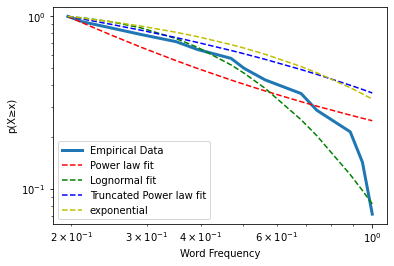

In [105]:
powerlaw2(G_single_pos)

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 12.3787 x ^ -2.0537 (k_min = 9)
(-1.197342875538296, 0.12174821302619776)
(-0.9711597791436574, 0.4467349300563487)
(-1.3269919581519665, 0.4056065721227424)
(-0.3558321790083092, 0.3213195112533628)
(0.22618309639463846, 0.5976288452877965)
(-0.12964908261367075, 0.8561611821565979)


Assuming nested distributions


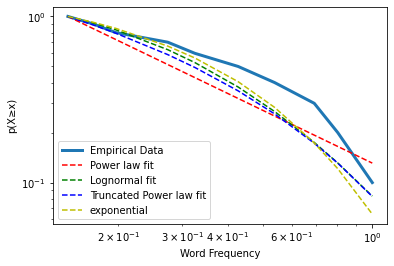

In [101]:
powerlaw2(G_single_neg)